# Restormer: Efficient Transformer for High-Resolution Image Restoration (CVPR 2022 -- Oral) [![paper](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/abs/2111.09881)

<hr />

This is a demo to run Restormer on you own images for the following tasks
- Real Image Denoising
- Single-Image Defocus Deblurring
- Single-Image Motion Deblurring
- Image Deraining


# 1. Setup
- First, in the **Runtime** menu -> **Change runtime type**, make sure to have ```Hardware Accelerator = GPU```
- Clone repo and install dependencies.


In [ ]:
# prompt: driver mount

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import os
!pip install einops

if os.path.isdir('Restormer'):
  !rm -r Restormer

# Clone Restormer
!git clone https://github.com/swz30/Restormer.git
%cd Restormer


Cloning into 'Restormer'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (309/309), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 309 (delta 122), reused 261 (delta 113), pack-reused 0 (from 0)
Receiving objects: 100% (309/309), 1.56 MiB | 11.48 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Updating files: 100% (120/120), done.
/content/drive/MyDrive/Restormer


# 2. Define Task and Download Pre-trained Models
Uncomment the task you would like to perform

In [ ]:
# prompt: file upload

# from google.colab import files
# uploaded = files.upload("Denoising/pretrained_models")

In [ ]:
task = 'Real_Denoising'
#task = 'Single_Image_Defocus_Deblurring'
# task = 'Motion_Deblurring'
# task = 'Deraining'

# # Download the pre-trained models
# if task is 'Real_Denoising':
  # !wget https://github.com/swz30/Restormer/releases/download/v1.0/real_denoising.pth -P Denoising/pretrained_models
# if task is 'Single_Image_Defocus_Deblurring':
#   !wget https://github.com/swz30/Restormer/releases/download/v1.0/single_image_defocus_deblurring.pth -P Defocus_Deblurring/pretrained_models
# if task is 'Motion_Deblurring':
#   !wget https://github.com/swz30/Restormer/releases/download/v1.0/motion_deblurring.pth -P Motion_Deblurring/pretrained_models
# if task is 'Deraining':
#   !wget https://github.com/swz30/Restormer/releases/download/v1.0/deraining.pth -P Deraining/pretrained_models


# 3. Upload Images
Either download the sample images or upload your own images

In [ ]:
# import os
# import shutil
# from google.colab import files

# # Download sample images
# # !rm -r demo/*
# # !wget https://github.com/swz30/Restormer/releases/download/v1.0/sample_images.zip -P demo
# # shutil.unpack_archive('demo/sample_images.zip', 'demo/')
# # os.remove('demo/sample_images.zip')

# # OR Uncomment the following block if you would like to upload your own images.

# !rm -r demo/*
# input_dir = 'demo/sample_images/'+task+'/degraded'
# os.makedirs(input_dir, exist_ok=True)
# uploaded = files.upload()
# for filename in uploaded.keys():
#   input_path = os.path.join(input_dir, filename)
#   shutil.move(filename, input_path)

# 4. Prepare Model and Load Checkpoint

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from runpy import run_path
from skimage import img_as_ubyte
from natsort import natsorted
from glob import glob
import cv2
from tqdm import tqdm
import numpy as np

def get_weights_and_parameters(task, parameters):
    if task == 'Motion_Deblurring':
        weights = os.path.join('Motion_Deblurring', 'pretrained_models', 'motion_deblurring.pth')
    elif task == 'Single_Image_Defocus_Deblurring':
        weights = os.path.join('Defocus_Deblurring', 'pretrained_models', 'single_image_defocus_deblurring.pth')
    elif task == 'Deraining':
        weights = os.path.join('Deraining', 'pretrained_models', 'deraining.pth')
    elif task == 'Real_Denoising':
        weights = '/content/drive/MyDrive/Restormer/Denoising/pretrained_models/real_denoising.pth'
        parameters['LayerNorm_type'] =  'BiasFree'
    return weights, parameters


# Get model weights and parameters
parameters = {'inp_channels':3, 'out_channels':3, 'dim':48, 'num_blocks':[4,6,6,8], 'num_refinement_blocks':4, 'heads':[1,2,4,8], 'ffn_expansion_factor':2.66, 'bias':False, 'LayerNorm_type':'WithBias', 'dual_pixel_task':False}
weights, parameters = get_weights_and_parameters(task, parameters)

# load_arch = run_path(os.path.join('basicsr', 'models', 'archs', 'restormer_arch.py'))
load_arch = run_path('/content/drive/MyDrive/Restormer/basicsr/models/archs/restormer_arch.py')
model = load_arch['Restormer'](**parameters)
model.cuda()

model.load_state_dict(torch.load(weights))
model.eval()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Restormer/Denoising/pretrained_models/real_denoising.pth'

# Training

In [ ]:
# import dataset
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import CenterCrop, Resize

class CustomDataset(Dataset):
    def __init__(self, clean_image_paths, noisy_image_paths, transform=None):
        self.clean_image_paths = [os.path.join(clean_image_paths, x) for x in os.listdir(clean_image_paths)]
        self.noisy_image_paths = [os.path.join(noisy_image_paths, x) for x in os.listdir(noisy_image_paths)]
        self.transform = transform
        self.center_crop = CenterCrop(1080)
        self.resize = Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE']))

        # Create a list of (noisy, clean) pairs
        self.noisy_clean_pairs = self._create_noisy_clean_pairs()

    def _create_noisy_clean_pairs(self):
        clean_to_noisy = {}
        for clean_path in self.clean_image_paths:
            clean_id = '_'.join(os.path.basename(clean_path).split('_')[:-1])
            clean_to_noisy[clean_id] = clean_path

        noisy_clean_pairs = []
        for noisy_path in self.noisy_image_paths:
            noisy_id = '_'.join(os.path.basename(noisy_path).split('_')[:-1])
            if noisy_id in clean_to_noisy:
                clean_path = clean_to_noisy[noisy_id]
                noisy_clean_pairs.append((noisy_path, clean_path))
            else:
                pass

        return noisy_clean_pairs

    def __len__(self):
        return len(self.noisy_clean_pairs)

    def __getitem__(self, index):
        noisy_image_path, clean_image_path = self.noisy_clean_pairs[index]

        noisy_image = Image.open(noisy_image_path).convert("RGB")
        clean_image = Image.open(clean_image_path).convert("RGB")

        # Central Crop and Resize
        noisy_image = self.center_crop(noisy_image)
        clean_image = self.center_crop(clean_image)
        noisy_image = self.resize(noisy_image)
        clean_image = self.resize(clean_image)

        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)

        return noisy_image, clean_image

In [ ]:
import os
import shutil

import random
import numpy as np
import time
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import CenterCrop, Resize
from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')


In [ ]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':5e-4,
    'BATCH_SIZE':2,
    'SEED':42
}

In [ ]:
import tqdm

# 시작 시간 기록
start_time = time.time()
model.train()

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, mode='fan_in', nonlinearity='relu')

def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 데이터셋 경로
noisy_image_paths = '/content/drive/MyDrive/Training/fuck_noisy'
clean_image_paths = '/content/drive/MyDrive/Training/clean'

# 데이터셋 로드 및 전처리
train_transform = Compose([
    ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 커스텀 데이터셋 인스턴스 생성
train_dataset = CustomDataset(clean_image_paths, noisy_image_paths, transform=train_transform)

# 전체 데이터셋 크기의 10% 계산
subset_size = int(len(train_dataset) * 0.05)

# Random sampler 생성
from torch.utils.data import SubsetRandomSampler
import numpy as np

# 전체 인덱스에서 랜덤하게 10% 선택
indices = np.random.permutation(len(train_dataset))
subset_indices = indices[:subset_size]
sampler = SubsetRandomSampler(subset_indices)

# 데이터 로더 설정
num_cores = os.cpu_count()
# 새로운 DataLoader 생성 (sampler 사용)
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG['BATCH_SIZE'],
    num_workers=2,
    sampler=sampler  # shuffle=True 대신 sampler 사용
)

# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 손실 함수와 최적화 알고리즘 설정
optimizer = optim.AdamW(model.parameters(), lr = CFG['LEARNING_RATE'], weight_decay=1e-4)
criterion = nn.MSELoss()
scaler = GradScaler()
scheduler = CosineAnnealingLR(optimizer, T_max=50)

# 모델의 파라미터 수 계산
total_parameters = count_parameters(model)
print("Total Parameters:", total_parameters)

# 모델 학습
model.train()
best_loss = 1000

for epoch in range(1, 50):
    model.train()
    epoch_start_time = time.time()
    mse_running_loss = 0.0

    for noisy_images, clean_images in tqdm.tqdm(train_loader):
        noisy_images = noisy_images.to(device)
        clean_images = clean_images.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(noisy_images)
            mse_loss = criterion(outputs, clean_images)

            # show sampled output and clean_image
            # Detach and move to CPU for display
            sampled_output = outputs[0].detach().cpu().numpy().transpose(1, 2, 0)
            sampled_clean = clean_images[0].detach().cpu().numpy().transpose(1, 2, 0)

            # Rescale to [0, 1] for display purposes
            sampled_output = (sampled_output * 0.5 + 0.5).clip(0, 1)
            sampled_clean = (sampled_clean * 0.5 + 0.5).clip(0, 1)

            # Display images using matplotlib
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(noisy_images[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.title("Noisy Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(sampled_output)
            plt.title("Model Output")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(sampled_clean)
            plt.title("Clean Image")
            plt.axis("off")

            plt.show()

        scaler.scale(mse_loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        mse_running_loss += mse_loss.item() * noisy_images.size(0)

    current_lr = scheduler.get_last_lr()[0]
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    minutes = int(epoch_time // 60)
    seconds = int(epoch_time % 60)
    hours = int(minutes // 60)
    minutes = int(minutes % 60)

    mse_epoch_loss = mse_running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{CFG['EPOCHS']}, MSE Loss: {mse_epoch_loss:.4f}, Lr: {current_lr:.8f}")
    print(f"1epoch 훈련 소요 시간: {hours}시간 {minutes}분 {seconds}초")

    class CustomDatasetTest(data.Dataset):
      def __init__(self, noisy_image_paths, transform=None):
          self.noisy_image_paths = [os.path.join(noisy_image_paths, x) for x in os.listdir(noisy_image_paths)]
          self.transform = transform

      def __len__(self):
          return len(self.noisy_image_paths)

      def __getitem__(self, index):
          noisy_image_path = self.noisy_image_paths[index]
          noisy_image = load_img(self.noisy_image_paths[index])

          # Convert numpy array to PIL image
          if isinstance(noisy_image, np.ndarray):
              noisy_image = Image.fromarray(noisy_image)

          if self.transform:
              noisy_image = self.transform(noisy_image)

          return noisy_image, noisy_image_path


    test_transform = Compose([
        ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

    def load_img(filepath):
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img


    # GPU 사용 여부 확인
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    # 데이터셋 경로
    test_data_path = '/content/drive/MyDrive/Blur_Input'
    output_path = '/content/drive/MyDrive/submission'

    # 데이터셋 로드 및 전처리
    test_dataset = CustomDatasetTest(test_data_path, transform=test_transform)

    # 데이터 로더 설정
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # 이미지 denoising 및 저장
    for noisy_image, noisy_image_path in test_loader:
        noisy_image = noisy_image.to(device)
        denoised_image = model(noisy_image)

        # denoised_image를 CPU로 이동하여 이미지 저장
        denoised_image = denoised_image.cpu().squeeze(0)
        denoised_image = denoised_image * torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(denoised_image.device) + torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(denoised_image.device)
        denoised_image = denoised_image.clamp(0, 1)
        denoised_image = transforms.ToPILImage()(denoised_image)

        # Save denoised image
        output_filename = noisy_image_path[0]
        denoised_filename = output_path + '/{:02d}/'.format(epoch) + output_filename.split('/')[-1][:-4] + '.jpg'
        denoised_image.save(denoised_filename)

        print(f'Saved denoised image: {denoised_filename}')

    if mse_epoch_loss < best_loss:
        best_loss = mse_epoch_loss
        torch.save(model.state_dict(), 'best_Restormer.pth')
        print(f"{epoch+1}epoch 모델 저장 완료")

# 종료 시간 기록
end_time = time.time()

# 소요 시간 계산
training_time = end_time - start_time
minutes = int(training_time // 60)
seconds = int(training_time % 60)
hours = int(minutes // 60)
minutes = int(minutes % 60)

# 결과 출력
print(f"훈련 소요 시간: {hours}시간 {minutes}분 {seconds}초")

In [ ]:

class CustomDatasetTest(data.Dataset):
      def __init__(self, noisy_image_paths, transform=None):
          self.noisy_image_paths = [os.path.join(noisy_image_paths, x) for x in os.listdir(noisy_image_paths)]
          self.transform = transform

      def __len__(self):
          return len(self.noisy_image_paths)

      def __getitem__(self, index):
          noisy_image_path = self.noisy_image_paths[index]
          noisy_image = load_img(self.noisy_image_paths[index])

          # Convert numpy array to PIL image
          if isinstance(noisy_image, np.ndarray):
              noisy_image = Image.fromarray(noisy_image)

          if self.transform:
              noisy_image = self.transform(noisy_image)

          return noisy_image, noisy_image_path


test_transform = Compose([
    ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# 데이터셋 경로
test_data_path = '/content/drive/MyDrive/Blur_Input'
output_path = '/content/drive/MyDrive/submission'

# 데이터셋 로드 및 전처리
test_dataset = CustomDatasetTest(test_data_path, transform=test_transform)

# 데이터 로더 설정
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

if not os.path.exists(output_path):
    os.makedirs(output_path)

# 이미지 denoising 및 저장
for noisy_image, noisy_image_path in test_loader:
    noisy_image = noisy_image.to(device)
    denoised_image = model(noisy_image)

    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    denoised_image = denoised_image * torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(denoised_image.device) + torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(denoised_image.device)
    denoised_image = denoised_image.clamp(0, 1)
    denoised_image = transforms.ToPILImage()(denoised_image)

    # Save denoised image
    output_filename = noisy_image_path[0]
    !mkdir -p /content/drive/MyDrive/submission/{:02epoch}
    denoised_filename = output_path + '/{:02d}/'.format(epoch) + output_filename.split('/')[-1][:-4] + '.jpg'
    denoised_image.save(denoised_filename)

    print(f'Saved denoised image: {denoised_filename}')

if mse_epoch_loss < best_loss:
    best_loss = mse_epoch_loss
    torch.save(model.state_dict(), 'best_Restormer.pth')
    print(f"{epoch+1}epoch 모델 저장 완료")

Saved denoised image: /content/drive/MyDrive/submission/00/TEST_203.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_005.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_165.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_011.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_164.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_158.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_206.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_170.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_004.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_210.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_038.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_159.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_010.jpg
Saved denoised image: /content/drive/MyDrive/submission/00/TEST_

In [ ]:
!nvidia-smi

Sat Nov  2 15:43:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              51W / 400W |  19273MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Inference

In [ ]:
class CustomDatasetTest(data.Dataset):
    def __init__(self, noisy_image_paths, transform=None):
        self.noisy_image_paths = [os.path.join(noisy_image_paths, x) for x in os.listdir(noisy_image_paths)]
        self.transform = transform

    def __len__(self):
        return len(self.noisy_image_paths)

    def __getitem__(self, index):
        noisy_image_path = self.noisy_image_paths[index]
        noisy_image = load_img(self.noisy_image_paths[index])

        # Convert numpy array to PIL image
        if isinstance(noisy_image, np.ndarray):
            noisy_image = Image.fromarray(noisy_image)

        if self.transform:
            noisy_image = self.transform(noisy_image)

        return noisy_image, noisy_image_path


test_transform = Compose([
    ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# 데이터셋 경로
test_data_path = '/content/drive/MyDrive/Blur_Input'
output_path = '/content/drive/MyDrive/submission'

# 데이터셋 로드 및 전처리
test_dataset = CustomDatasetTest(test_data_path, transform=test_transform)

# 데이터 로더 설정
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

if not os.path.exists(output_path):
    os.makedirs(output_path)

# 이미지 denoising 및 저장
for noisy_image, noisy_image_path in test_loader:
    noisy_image = noisy_image.to(device)
    denoised_image = model(noisy_image)

    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    denoised_image = denoised_image * torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(denoised_image.device) + torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(denoised_image.device)
    denoised_image = denoised_image.clamp(0, 1)
    denoised_image = transforms.ToPILImage()(denoised_image)

    plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(noisy_image.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))
    # plt.title("Noisy Image")
    # plt.axis("off")

    # plt.subplot(1, 2, 2)
    # plt.imshow(denoised_image)
    # plt.title("Model Output")
    # plt.axis("off")

    # Save denoised image
    output_filename = noisy_image_path[0]
    denoised_filename = output_path + '/' + output_filename.split('/')[-1][:-4] + '.jpg'
    denoised_image.save(denoised_filename)

    print(f'Saved denoised image: {denoised_filename}')

Saved denoised image: /content/drive/MyDrive/submission/TEST_210.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_199.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_166.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_173.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_167.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_172.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_211.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_007.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_013.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_205.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_198.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_174.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_160.jpg
Saved denoised image: /content/drive/MyDrive/submission/TEST_148.jpg
Saved denoised image: /content/dri

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

# 5. Inference

In [ ]:
input_dir = 'demo/sample_images/'+task+'/degraded'
out_dir = 'demo/sample_images/'+task+'/restored'
os.makedirs(out_dir, exist_ok=True)
extensions = ['jpg', 'JPG', 'png', 'PNG', 'jpeg', 'JPEG', 'bmp', 'BMP']
files = natsorted(glob(os.path.join(input_dir, '*')))

img_multiple_of = 8

print(f"\n ==> Running {task} with weights {weights}\n ")
with torch.no_grad():
  for filepath in tqdm(files):
      # print(file_)
      torch.cuda.ipc_collect()
      torch.cuda.empty_cache()
      img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
      input_ = torch.from_numpy(img).float().div(255.).permute(2,0,1).unsqueeze(0).cuda()

      # Pad the input if not_multiple_of 8
      h,w = input_.shape[2], input_.shape[3]
      H,W = ((h+img_multiple_of)//img_multiple_of)*img_multiple_of, ((w+img_multiple_of)//img_multiple_of)*img_multiple_of
      padh = H-h if h%img_multiple_of!=0 else 0
      padw = W-w if w%img_multiple_of!=0 else 0
      input_ = F.pad(input_, (0,padw,0,padh), 'reflect')

      restored = model(input_)
      restored = torch.clamp(restored, 0, 1)

      # Unpad the output
      restored = restored[:,:,:h,:w]

      restored = restored.permute(0, 2, 3, 1).cpu().detach().numpy()
      restored = img_as_ubyte(restored[0])

      filename = os.path.split(filepath)[-1]
      cv2.imwrite(os.path.join(out_dir, filename),cv2.cvtColor(restored, cv2.COLOR_RGB2BGR))


 ==> Running Real_Denoising with weights /content/drive/MyDrive/Restormer/Denoising/pretrained_models/real_denoising.pth
 


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


# 6. Visualize Results


Results: Real_Denoising


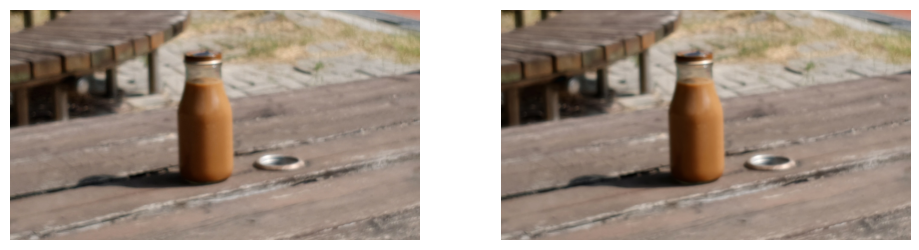

In [ ]:
import matplotlib.pyplot as plt
inp_filenames = natsorted(glob(os.path.join(input_dir, '*')))
out_filenames = natsorted(glob(os.path.join(out_dir, '*')))

## Will display only first 5 images
num_display_images = 5
if len(inp_filenames)>num_display_images:
  inp_filenames = inp_filenames[:num_display_images]
  out_filenames = out_filenames[:num_display_images]

print(f"Results: {task}")
for inp_file, out_file in zip(inp_filenames, out_filenames):
  degraded = cv2.cvtColor(cv2.imread(inp_file), cv2.COLOR_BGR2RGB)
  restored = cv2.cvtColor(cv2.imread(out_file), cv2.COLOR_BGR2RGB)
  ## Display Images
  fig, axes = plt.subplots(nrows=1, ncols=2)
  dpi = fig.get_dpi()
  fig.set_size_inches(900/ dpi, 448 / dpi)
  plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
  axes[0].axis('off')
  axes[0].imshow(degraded)
  axes[1].axis('off')
  axes[1].imshow(restored)
  plt.show()

# 7. Download Results

In [ ]:
from google.colab import files
zip_filename = f"Restormer_{task}.zip"
os.system(f"zip -r {zip_filename} demo/sample_images/{task}")
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>